<a href="https://colab.research.google.com/github/florianrougier/IEEE-CIS-Fraud-Detection/blob/master/Logistic_regression_IEEE_Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data and libraries import 

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = 'xxxxxxxx'
os.environ['KAGGLE_KEY'] = 'xxxxxxxxxxxxx'

In [0]:
!kaggle competitions download -c ieee-fraud-detection

train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
# The below lines are commented because they are annoying when i want to run all cells

'''!unzip train_identity.csv.zip
!unzip train_transaction.csv.zip
!unzip test_identity.csv.zip
!unzip test_transaction.csv.zip'''



'!unzip train_identity.csv.zip\n!unzip train_transaction.csv.zip\n!unzip test_identity.csv.zip\n!unzip test_transaction.csv.zip'

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [0]:
train = import_data('train_transaction.csv')
test = import_data('test_transaction.csv')

Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%


In [0]:
%%time
'''train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')'''

CPU times: user 22 µs, sys: 1e+03 ns, total: 23 µs
Wall time: 26.7 µs


"train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')\ntest = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')"

In [0]:
print(f'The training data contains {train.shape[0]} rows and {train.shape[1]} columns')
print(f'The testing data contains {test.shape[0]} rows and {test.shape[1]} columns')

The training data contains 590540 rows and 394 columns
The testing data contains 506691 rows and 393 columns


## Preliminary visualization

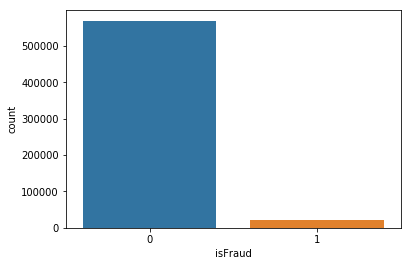

In [0]:
sns.countplot(x='isFraud', data=train)

The data is strongly imbalanced: we will need to use techniques to prevent biased predictions

##Data preprocessing

During this step, we'll try to get more familiar with the data.

We already know the numbrer of rows and columns for both the training and the testing data. We would want to know if there are a lot of missing values and a lot of duplicates.

Then, we would like to see some visuals informing us about the data distribution.


Todo:

- Remove columns with too many missing values (threshold to define)

- Encode categorical variables

- Replace numerical missing values using a certain technique (mean of the column, median...)

### Removing colmuns with too many missing values

In [0]:
missing_values = train.notnull().sum().sort_values(ascending=False)
missing_per = ((missing_values)/len(train)) * 100
pd.concat([missing_values, missing_per], keys=['Missing Values', 'Not Missing %'], axis=1)

,Missing Values,Not Missing %
TransactionID,590540,100.000000
C6,590540,100.000000
C14,590540,100.000000
C13,590540,100.000000
C1,590540,100.000000
C11,590540,100.000000
C10,590540,100.000000
C9,590540,100.000000
C8,590540,100.000000
C7,590540,100.000000


In [0]:
def delete_too_much_missing_data(data):
    too_much_null_cols = [col for col in data.columns if data[col].isnull().sum()/data.shape[0]>0.8]
    return too_much_null_cols

In [0]:

new_train = train.drop(delete_too_much_missing_data(train), axis = 1)
new_test = test.drop(delete_too_much_missing_data(train), axis = 1) 
# We need to delete the same columns from train and test, so we delete data using the training dataset only

In [0]:
print(new_train.shape)
print(new_test.shape)

(590540, 339)
(506691, 338)


### Encoding categorical features

We need to encode categorical data. First let's see how many features are categorical out of the remaining columns (using a boolean mask).

In [0]:
def find_categorical(dataframe):
  # Categorical boolean mask
  categorical_feature_mask = dataframe.dtypes=="category"
  # filter categorical columns using mask and turn it into a list
  categorical_cols = dataframe.columns[categorical_feature_mask].tolist()
  return categorical_cols

In [0]:
categorical = find_categorical(new_train)

Using the get_dummies function from the pandas library (memory problem) / using label encoding instead


In [0]:
'''def get_dummies(dataframe):
  # Get dummies
  X = pd.get_dummies(dataframe, prefix_sep='_', drop_first=True)
  return X '''

"def get_dummies(dataframe):\n  # Get dummies\n  X = pd.get_dummies(dataframe, prefix_sep='_', drop_first=True)\n  return X "

In [0]:
'''# Replacing data by encoded data
new_train = get_dummies(new_train)
new_test = get_dummies(new_test)'''

'# Replacing data by encoded data\nnew_train = get_dummies(new_train)\nnew_test = get_dummies(new_test)'

In [0]:
'''# Label Encoding for categorical variables.
for f in new_test.columns:
  if new_train[f].dtype=='category' or new_test[f].dtype=='category': 
      lbl = preprocessing.LabelEncoder()
      lbl.fit(list(new_train[f].values) + list(new_test[f].values))
      new_train[f] = lbl.transform(list(new_train[f].values))
      new_test[f] = lbl.transform(list(new_test[f].values))'''

"# Label Encoding for categorical variables.\nfor f in new_test.columns:\n  if new_train[f].dtype=='category' or new_test[f].dtype=='category': \n      lbl = preprocessing.LabelEncoder()\n      lbl.fit(list(new_train[f].values) + list(new_test[f].values))\n      new_train[f] = lbl.transform(list(new_train[f].values))\n      new_test[f] = lbl.transform(list(new_test[f].values))"

In [0]:
new_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,T,T,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,T,T,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,NaN,111.0,NaN,NaN,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Too many columns: drop categorical variables

In [0]:
new_train = new_train.drop(find_categorical(new_train), axis = 1)
new_test = new_test.drop(find_categorical(new_test), axis = 1) 

In [0]:
new_test.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,3663549,18403224,31.953125,10409,111.0,150.0,226.0,170.0,87.0,1.0,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,418.0,203.0,409.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.0000,47.950001,0.0000,0.000000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
1,3663550,18403263,49.000000,4272,111.0,150.0,226.0,299.0,87.0,4.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,231.0,634.0,634.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.0000,280.000000,0.0000,77.000000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2,3663551,18403310,171.000000,4476,574.0,150.0,226.0,472.0,87.0,2636.0,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,136.0,136.0,97.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.0000,1058.000000,0.0000,0.000000,0.0000,0.000,0.0000,0.0,0.0,0.0,0.0,263.0,0.0
3,3663552,18403310,285.000000,10989,360.0,150.0,166.0,205.0,87.0,17.0,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,242.0,242.0,242.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000,282.5000,282.500,282.5000,0.0,0.0,0.0,0.0,0.0,0.0
4,3663553,18403317,67.937500,18018,452.0,150.0,117.0,264.0,87.0,6.0,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,22.0,22.0,22.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.9375,183.850006,67.9375,67.949997,67.9375,183.875,67.9375,0.0,0.0,0.0,0.0,0.0,0.0


### Replacing numerical missing values 

For now we will replace numerical missing values by -9999 

In [0]:
new_train = new_train.fillna(-9999)
new_test = new_test.fillna(-9999)

## Building a logistic regression model

Fiest we need to separate the independant variable from both the training and the testing set

In [0]:
X_train = new_train.drop("isFraud", axis = 1)
y_train = new_train["isFraud"]

Splitting the training data between a training set and validation set

In [0]:
from sklearn.model_selection import train_test_split
# Split the data into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

Then we can build the logistic regression model (parameters to adapt)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

model = LogisticRegression(class_weight='balanced').fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
parameters = model.coef_

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Visualizations

Here is a nice plot to show the confusion matrix showcasing the false positives and negatives cases:

1. Split the training data between a training set and a validation set
2. Make predictions on the validation set
3. Extract classes ("Fraud", "Non Fraud") 
4. Pass arguments to the funciton

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[82446 31511]
 [ 1330  2821]]
Normalized confusion matrix
[[0.72 0.28]
 [0.32 0.68]]


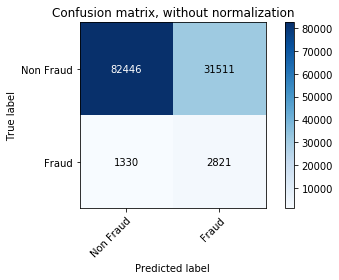

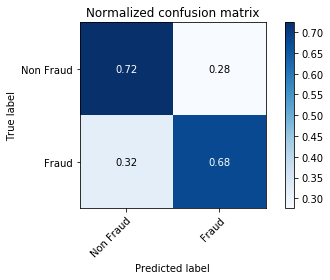

In [0]:
np.set_printoptions(precision=2)

# Defined predictions classes
class_names = ["Non Fraud", "Fraud"]

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_val, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Submitting results

In [0]:
import csv

y_sub_predict = model.predict_proba(new_test)
print(y_sub_predict)

csv_data = [['TransactionID', 'isFraud']]

fraud_dict = { 'fraud': 0, 'not_fraud': 0 }
for i in range(0, len(y_sub_predict)):
  csv_data.append([test['TransactionID'][i], y_sub_predict[i][0]])
  if y_sub_predict[i][0] >= 0.5:
    fraud_dict['fraud'] += 1
  else:
    fraud_dict['not_fraud'] += 1
print(fraud_dict)

[[0.84 0.16]
 [0.81 0.19]
 [0.52 0.48]
 ...
 [0.59 0.41]
 [0.57 0.43]
 [0.15 0.85]]
{'fraud': 271285, 'not_fraud': 235406}


In [0]:
with open('submission.csv', 'w') as csv_file:
  writer = csv.writer(csv_file)
  writer.writerows(csv_data)

csv_file.close()

In [0]:
# submit the file to kaggle
!kaggle competitions submit ieee-fraud-detection -f submission.csv -m "Second submission!"

100% 13.6M/13.6M [00:02<00:00, 6.74MB/s]
Successfully submitted to IEEE-CIS Fraud Detection